In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve, f1_score, classification_report

from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM, MultiHeadAttention, Add, GlobalAveragePooling1D, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
import tensorflow.keras.backend as K

In [2]:
def charge_npy(path):
    X = np.load(path)
    y = np.load(path.replace('X', 'y'))
    return X, y

In [3]:
# charge y_train.npy in Facenet Embeddings/Train/y_train.npy
path_train = '../../../Facenet Embeddings/Train/X_train.npy'
path_val = '../../../Facenet Embeddings/Val/X_val.npy'
path_test = '../../../Facenet Embeddings/Test/X_test.npy'
X_train, y_train = charge_npy(path_train)
X_val, y_val = charge_npy(path_val)
X_test, y_test = charge_npy(path_test)

n_frames = 5
embedding_dim = 128

X_train = X_train.reshape((-1, n_frames, embedding_dim))
y_train = y_train[:, 4:8]
y_train = np.mean(y_train.reshape(-1, 5, 4), axis=1)
y_train = np.argmax(y_train, axis=1)
## if in the first or second position exists a 1, then y is 0 and only has a shape of 1, else 1
##y_train = np.where((y_train[:, 3] == 1), 1, 0).reshape(-1, 1)

X_val = X_val.reshape((-1, n_frames, embedding_dim)) 
y_val = y_val[:, 4:8]
y_val = np.mean(y_val.reshape(-1, 5, 4), axis=1)
y_val = np.argmax(y_val, axis=1)
##y_val = np.where((y_val[:, 3] == 1), 1, 0).reshape(-1, 1)

X_test = X_test.reshape((-1, n_frames, embedding_dim))  
y_test = y_test[:, 4:8]
y_test = np.mean(y_test.reshape(-1, 5, 4), axis=1)
y_test = np.argmax(y_test, axis=1)

#y_test = np.mean(y_test.reshape(-1, 5, 4), axis=1)
##y_test = np.where((y_test[:, 3] == 1), 1, 0).reshape(-1, 1)

In [4]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [5]:
# Parámetros
n_models = 1
models = []
histories = []

# Callback EarlyStopping y ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=250, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, verbose=1)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Add()([x, inputs])  # Skip connection
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-Forward Network
    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    x = Add()([x, ff])  # Skip connection
    x = LayerNormalization(epsilon=1e-6)(x)

    return x

def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    # Transformer Encoder
    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)

    # Pooling + Dense
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(1e-4), metrics=["accuracy"])
    return model

# Creamos y entrenamos el modelo
model = build_transformer_model((X_train.shape[1], X_train.shape[2]))

history = model.fit(
    X_train,
    y_train,
    class_weight=class_weights,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/500
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3299 - loss: 1.6222 - val_accuracy: 0.2233 - val_loss: 1.5247 - learning_rate: 1.0000e-04
Epoch 2/500
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3115 - loss: 1.4868 - val_accuracy: 0.2698 - val_loss: 1.3780 - learning_rate: 1.0000e-04
Epoch 3/500
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3476 - loss: 1.2887 - val_accuracy: 0.2366 - val_loss: 1.3998 - learning_rate: 1.0000e-04
Epoch 4/500
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3419 - loss: 1.2637 - val_accuracy: 0.2855 - val_loss: 1.3153 - learning_rate: 1.0000e-04
Epoch 5/500
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3536 - loss: 1.2809 - val_accuracy: 0.2855 - val_loss: 1.3131 - learning_rate: 1.0000e-04
Epoch 6/500
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3606 - loss: 1.2448 - val_accuracy: 0.3064 - val_loss: 1.3037 - learning_rate: 1.0000e-04
Epoch 7/500
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc

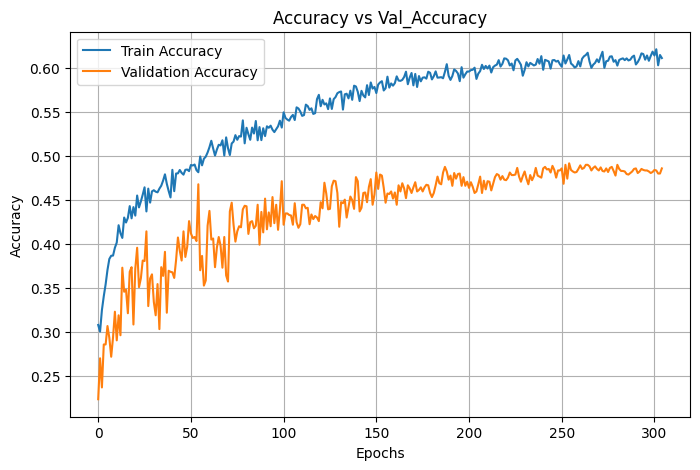

In [15]:
# Accuracy for 5 patience LR
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracy vs Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

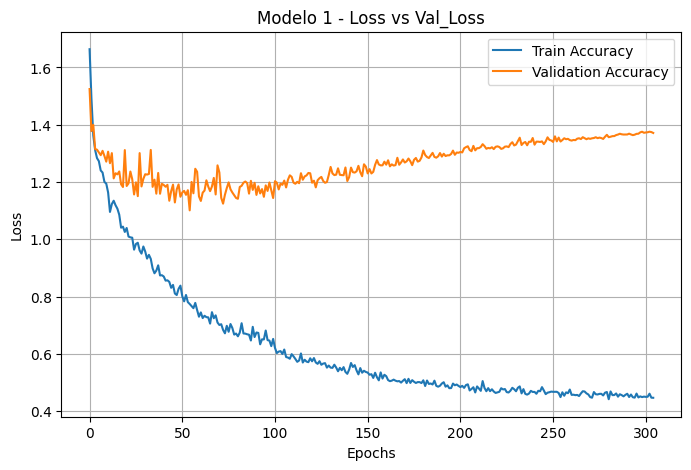

In [9]:
# Accuracy for 50 lr
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Accuracy')
plt.plot(history.history['val_loss'], label='Validation Accuracy')
plt.title(f'Modelo {1} - Loss vs Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Predicciones individuales de cada modelo
preds = model.predict(X_test)
final_preds = np.argmax(preds, axis=1)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


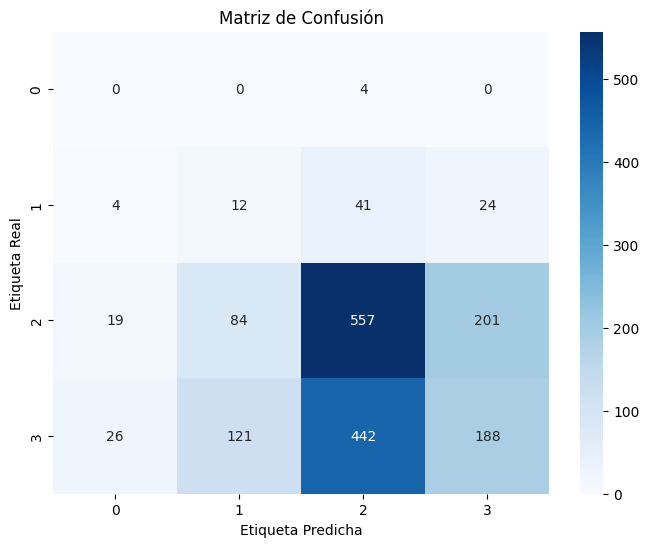

In [19]:
# 5 LR
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [21]:
# Classification report 5 LR
print(classification_report(y_test, final_preds, digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000         4
           1      0.055     0.148     0.081        81
           2      0.534     0.647     0.585       861
           3      0.455     0.242     0.316       777

    accuracy                          0.439      1723
   macro avg      0.261     0.259     0.245      1723
weighted avg      0.474     0.439     0.438      1723



In [22]:
# View metric UAR
def uar(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    uar = np.mean(np.diag(cm) / np.sum(cm, axis=1))
    return uar

uar_score = uar(y_test, final_preds)
print(f"UAR: {uar_score:.4f}")

UAR: 0.2593
